In [30]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
import math
import pandas as pd
import xgboost
import lightgbm
import catboost

from matplotlib.colors import ListedColormap
from scipy.stats import pearsonr
from itertools import combinations
from sklearn.base import BaseEstimator
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import (RandomForestClassifier,
                              ExtraTreesClassifier,
                              VotingClassifier)
from sklearn.tree import (DecisionTreeRegressor,
                          DecisionTreeClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (precision_score, recall_score, f1_score, accuracy_score,
                             confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay,
                             roc_curve, auc, roc_auc_score, classification_report)
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold

In [3]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

### Task 1. Bias-variance trade-off

Demonstrate bias-variance trade-off for `DecisionTreeRegressor` when changing tree depth. Build a regression model of the function from one independent variable, presented in the cell below, using the `plot_regression_predictions` function (you can change it somehow if you want). Try different values ​​of tree depth, at what value do you think the model is optimal, at what value does the variance become too large?

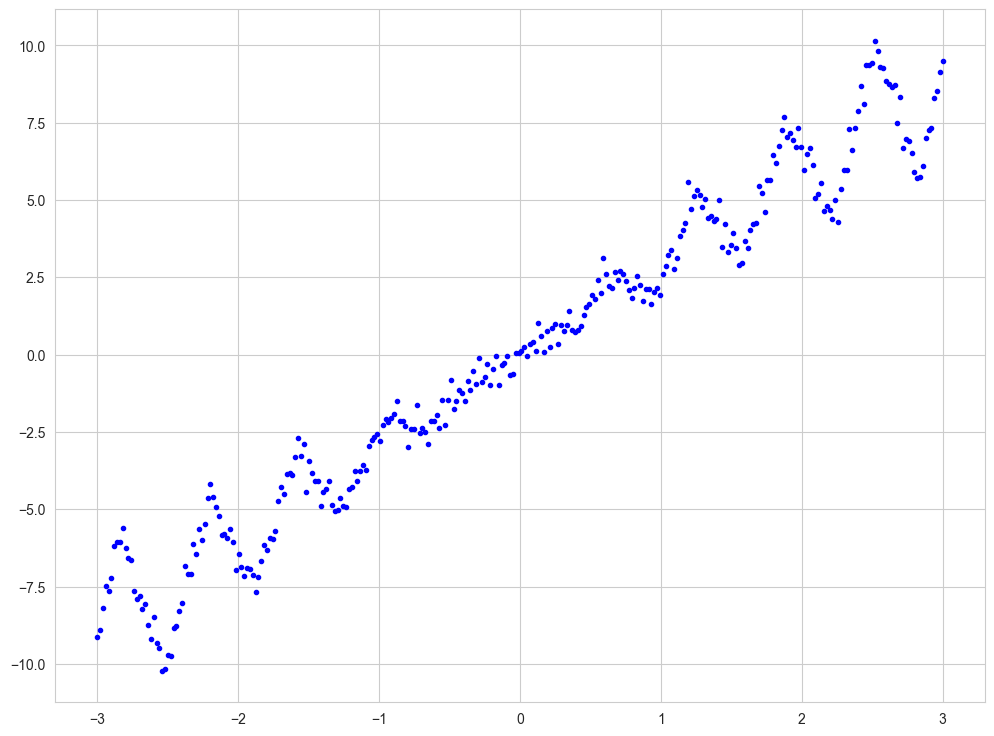

In [4]:
# Сгенерируем какую-нибудь необычную зависимость и научимся ее предсказывать
np.random.seed(42)
m = 300
X = np.linspace(-3, 3, m).reshape(-1, 1)
y = (3 + 2/np.pi * np.arcsin(np.cos(10 * X))) * X
y = y + np.random.randn(m, 1) / 3
plt.plot(X.reshape(-1), y.reshape(-1), "b.");

In [5]:
# Function for drawing predictions of decision trees in case of regression
def plot_regression_predictions(tree_reg, X, y, axes=[-3, 3, -10, 10], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)

    plt.plot(x1, y_pred, linewidth=2, label=r"$\hat{y}$")

Draw how the tree's predictions change as the maximum depth increases.


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

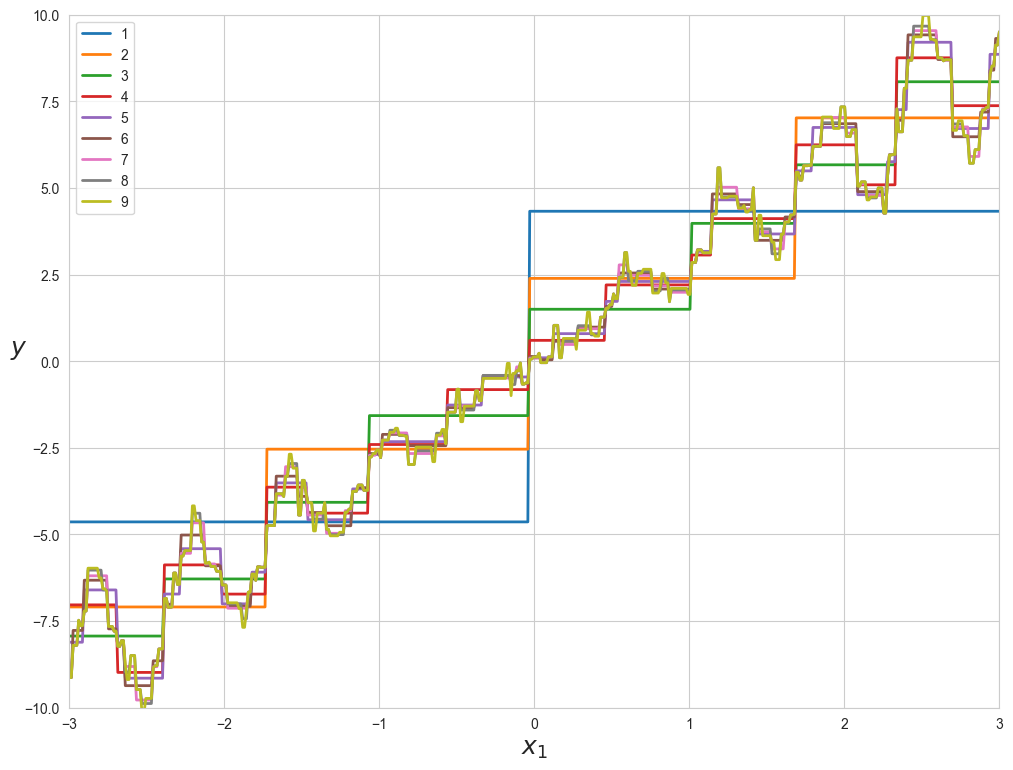

In [7]:
depth_range = range(1, 10)
for i in depth_range:
    model = DecisionTreeRegressor(max_depth=i)
    model.fit(X_train, y_train)
    plot_regression_predictions(model, X_test, y_test)
plt.legend(depth_range)

**In this case above max_depth=6 predictions are almost indistingushible. let's look how well it's correlated with test data for depth equal 3, 5 and 7**

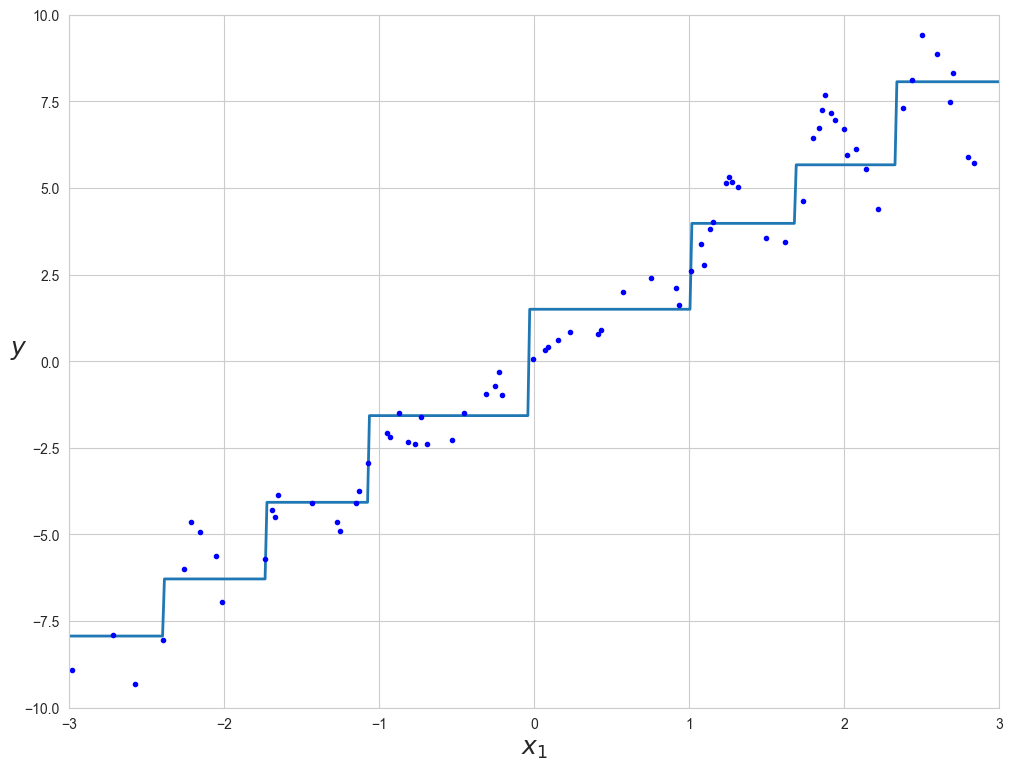

In [8]:
model = DecisionTreeRegressor(max_depth=3)
model.fit(X_train, y_train)
plot_regression_predictions(model, X_test, y_test)
plt.plot(X_test.reshape(-1), y_test.reshape(-1), "b.")

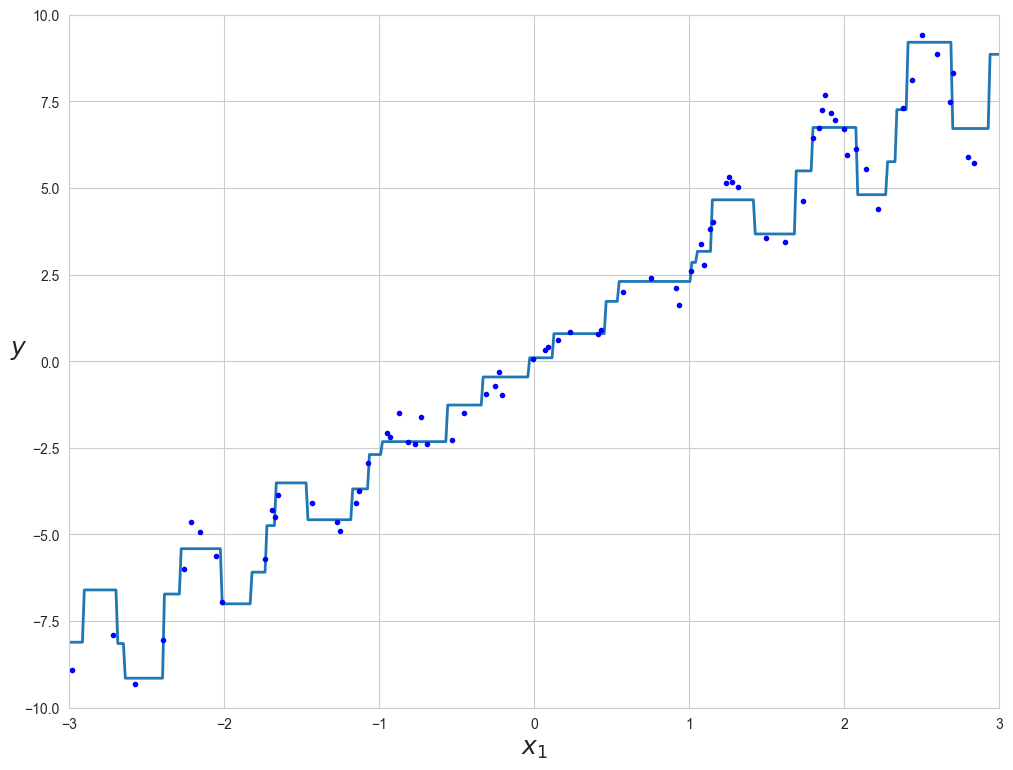

In [9]:
model = DecisionTreeRegressor(max_depth=5)
model.fit(X_train, y_train)
plot_regression_predictions(model, X_test, y_test)
plt.plot(X_test.reshape(-1), y_test.reshape(-1), "b.")

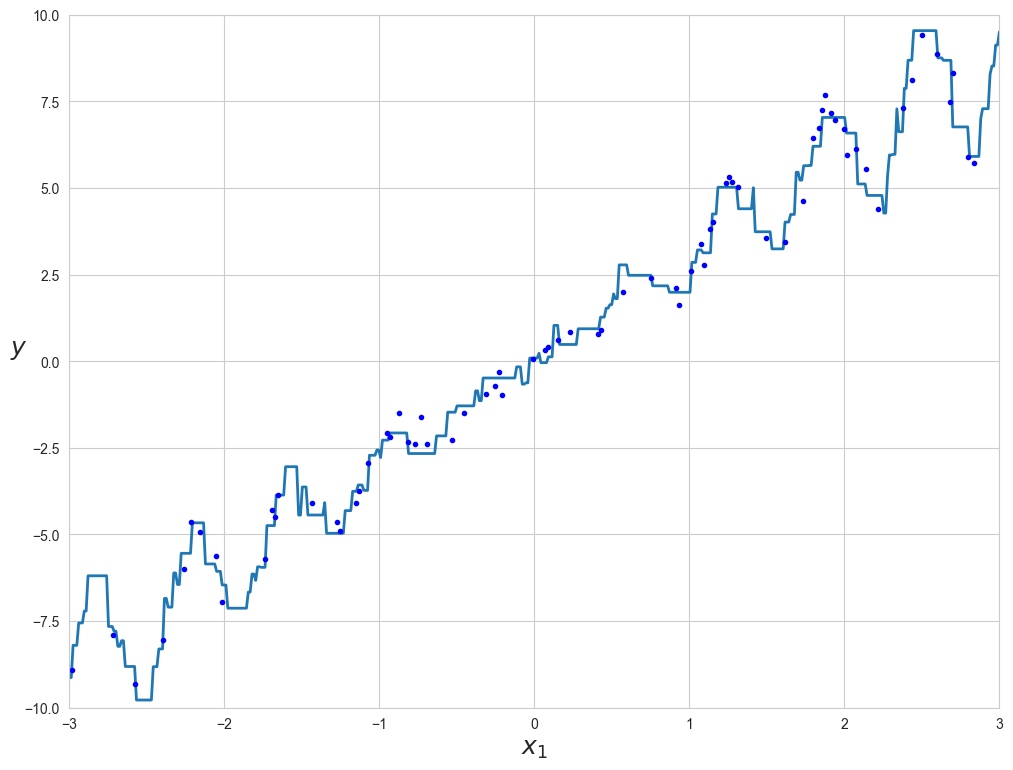

In [10]:
model = DecisionTreeRegressor(max_depth=7)
model.fit(X_train, y_train)
plot_regression_predictions(model, X_test, y_test)
plt.plot(X_test.reshape(-1), y_test.reshape(-1), "b.")

### Task 2. Random forest

Now let's do a little preparation to implement our own random forest, and then we'll implement it.

#### Task 2. 1. Simple ensemble


Let's imagine that we have 101 classifiers. Everyone can correctly predict the class of an object with probability `p` (equal for all models). We will make predictions based on the majority vote. Plot the probability of correctly classifying an object as a function of the `p` value. You may find the following formula helpful:

$$ \large \mu = \sum_ {i = 51} ^ {101} C_{101} ^ ip ^ i (1-p) ^ {101-i} $$

In [11]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##


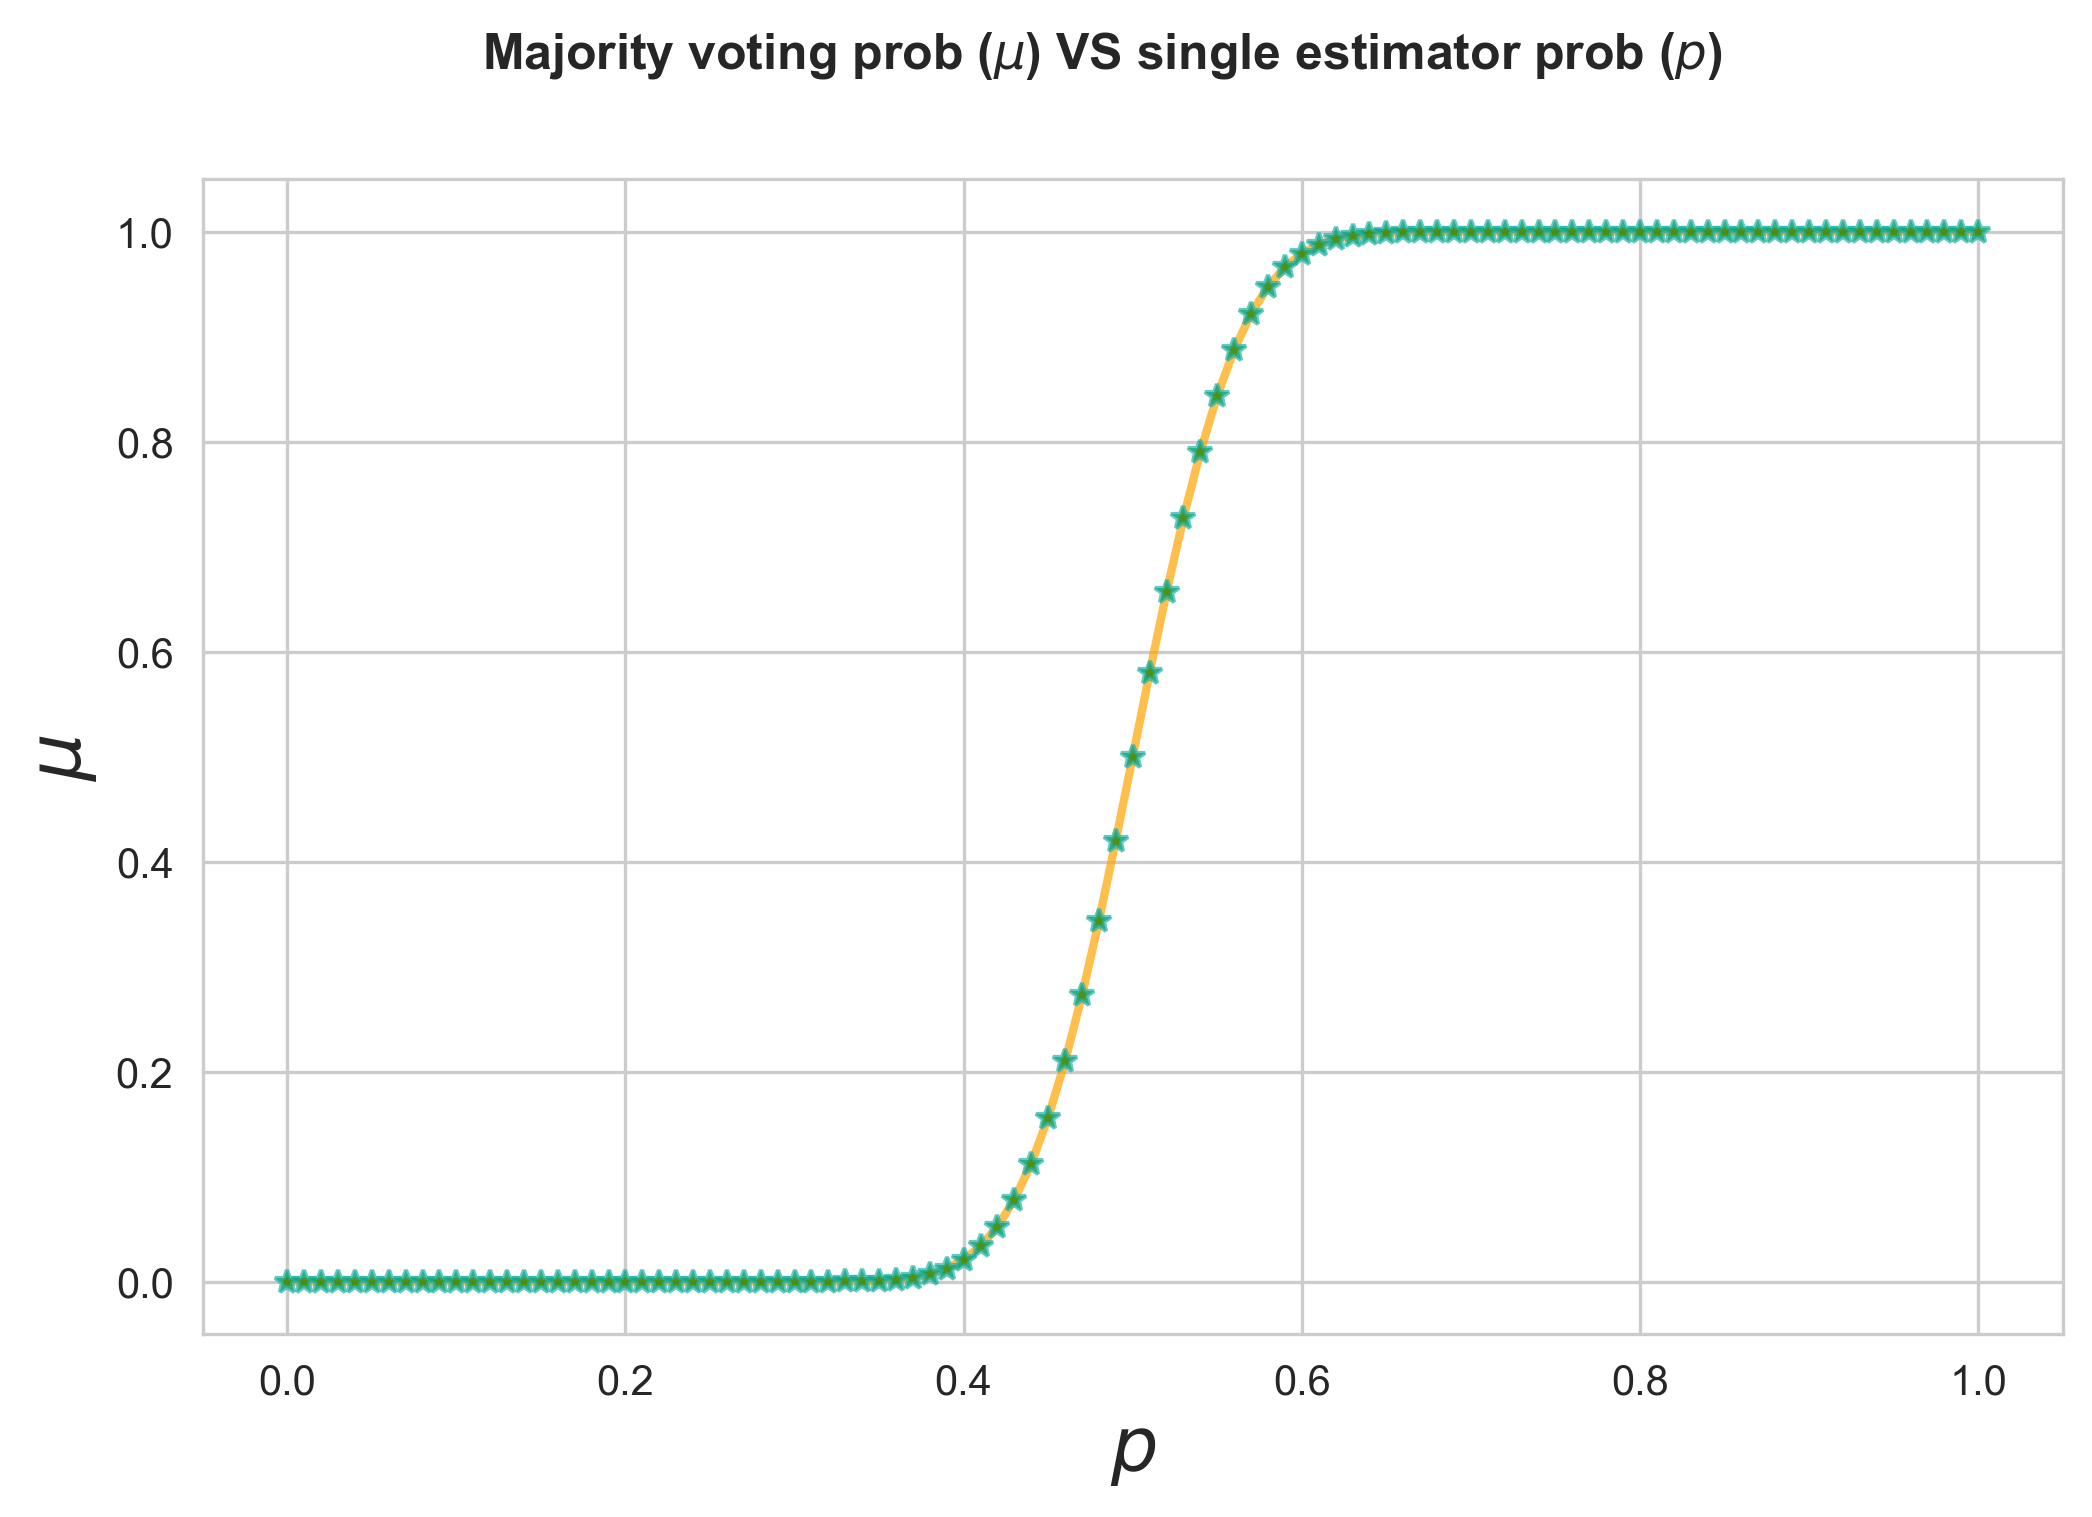

In [12]:
p_values = np.arange(0, 1.01, 0.01)
max_i = 101
min_i = 51
i_ = list(range(min_i, max_i+1))
mu = list(sum(math.comb(max_i, i) * p**i * (1 - p)**(max_i - i) for i in i_) for p in p_values)

fig, ax = plt.subplots(figsize=(8,5), dpi=300)
ax.plot(p_values, mu, linewidth=2, color="orange", alpha=0.7, marker="*", markersize=6, mec="lightseagreen", mfc="green")
ax.set_xlabel("$p$", fontsize=18, fontweight="bold")
ax.set_ylabel("$\mu$", fontsize=18, fontweight="bold")
fig.suptitle("Majority voting prob ($\mu$) VS single estimator prob ($p$)", 
             fontsize=12, fontweight="bold");

Now let's look at another situation. We have a fixed probability that the model correctly classifies the object `p = 0.65`. Plot the dependence of the probability of correctly classifying an object on the number of models in the ensemble.

In [13]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

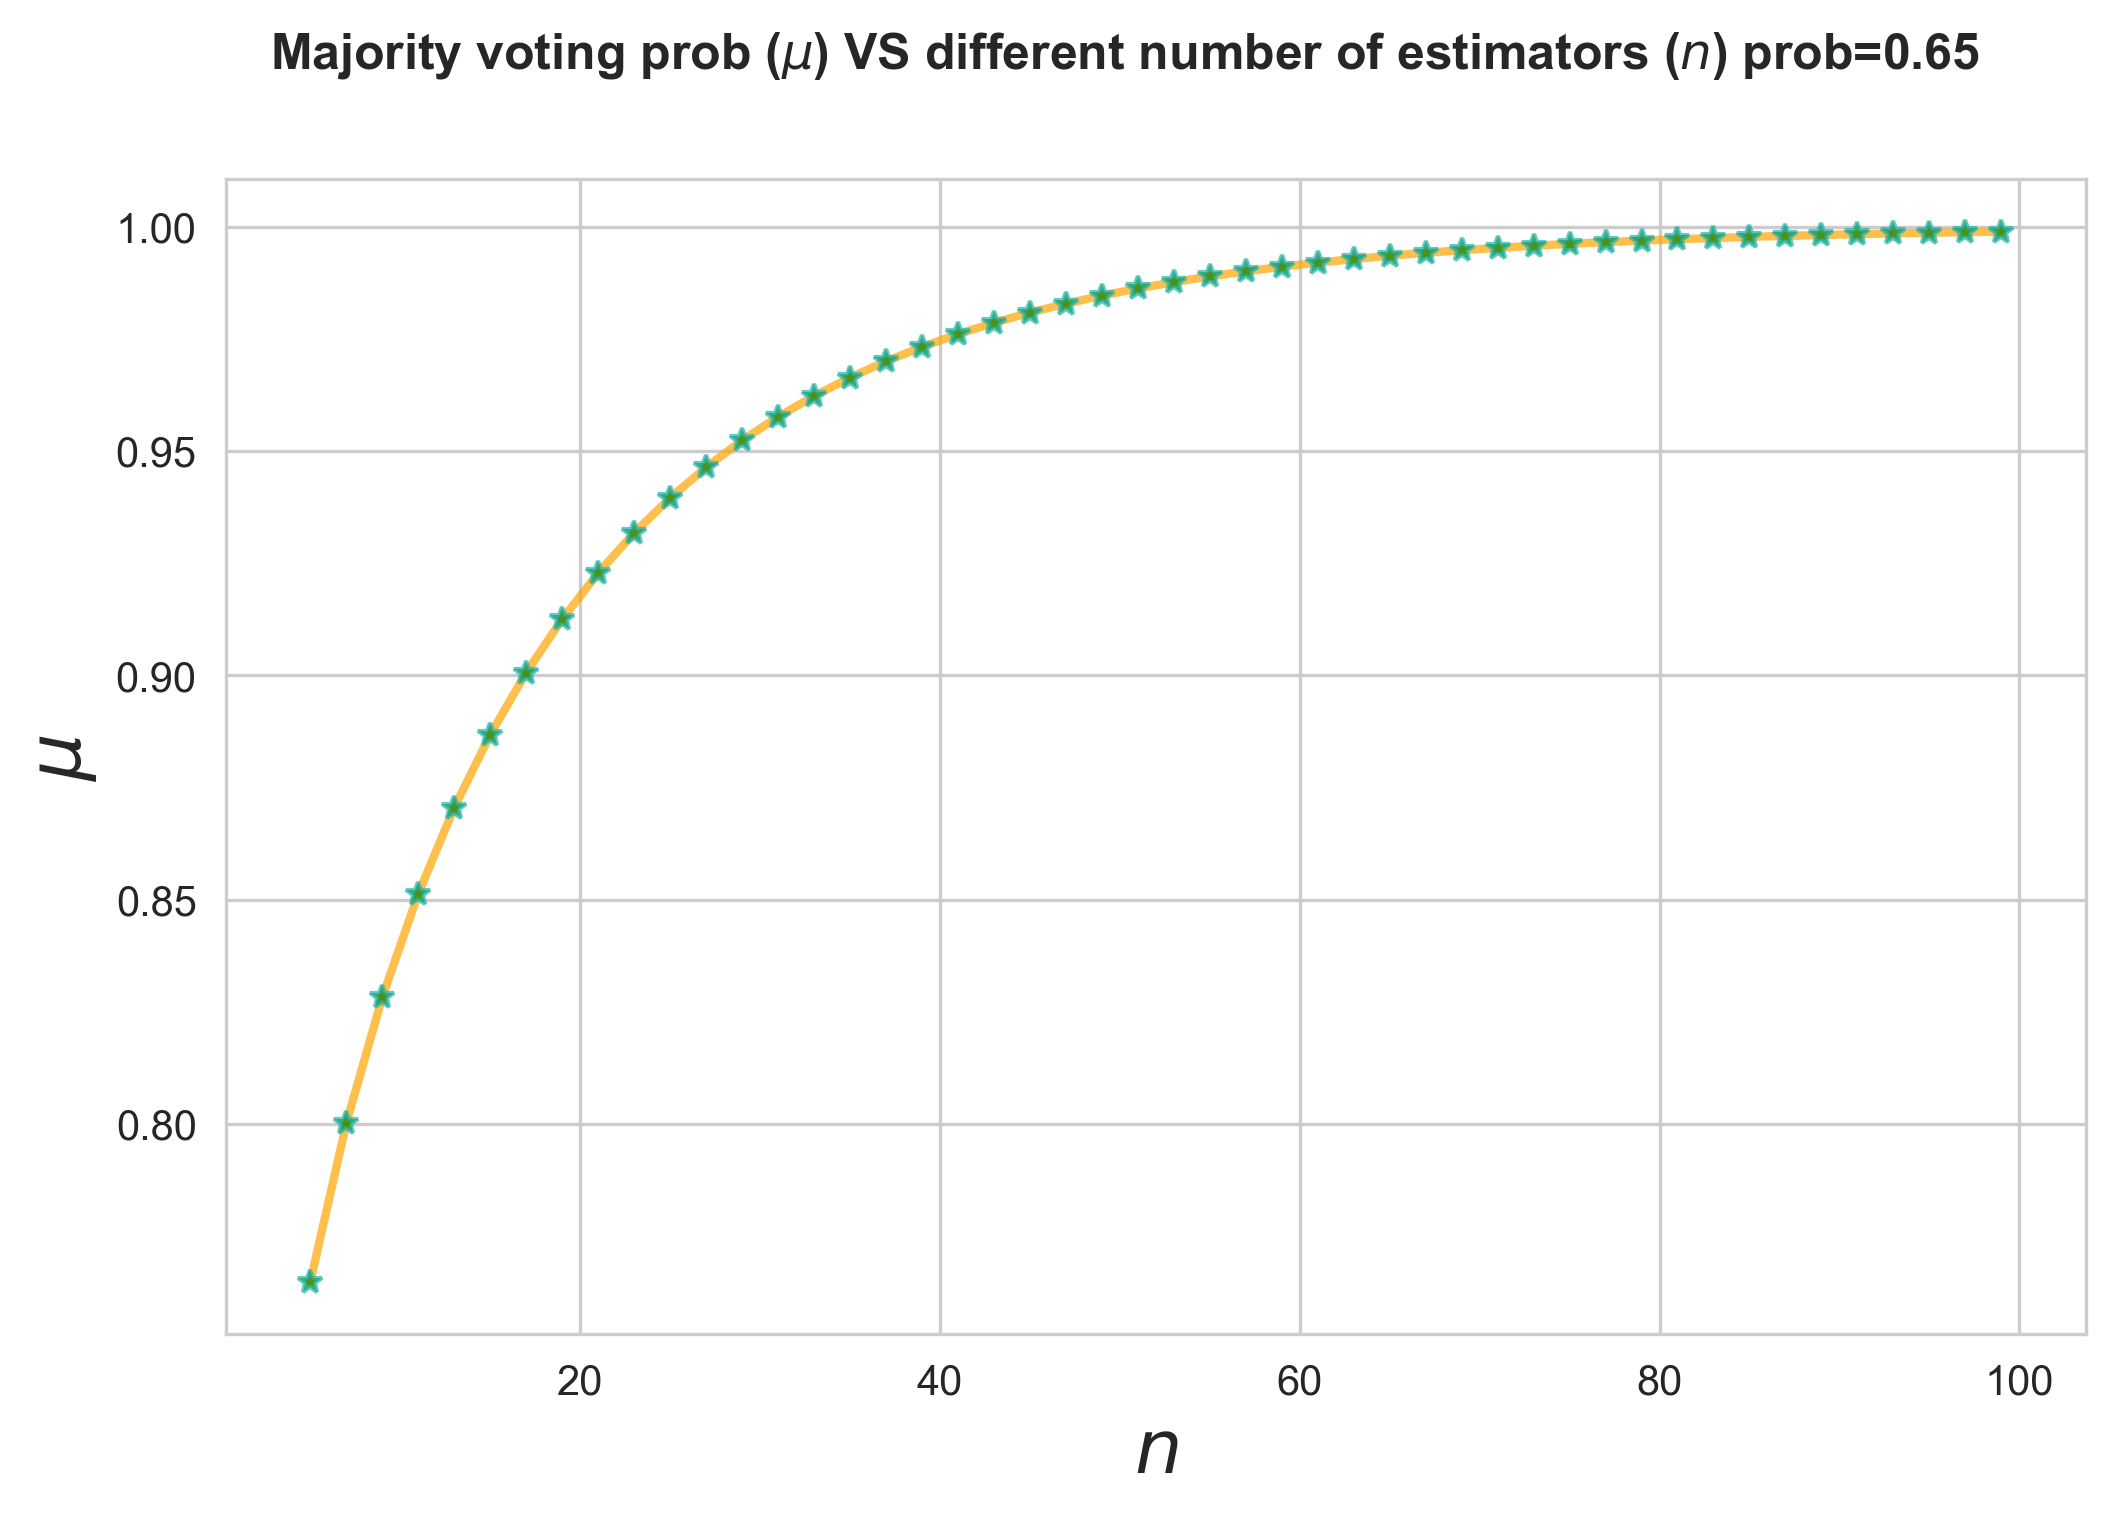

In [14]:
p = 0.65
max_is =  np.arange(5,101, 2)
mu = list(sum(math.comb(max_i, i) * p**i * (1 - p)**(max_i - i) for i in range(max_i//2+1, max_i+1)) for max_i in max_is)
fig, ax = plt.subplots(figsize=(8,5), dpi=300)
ax.plot(max_is, mu, linewidth=2, color="orange", alpha=0.7, marker="*", markersize=6, mec="lightseagreen", mfc="green")
ax.set_xlabel("$n$", fontsize=18, fontweight="bold")
ax.set_ylabel("$\mu$", fontsize=18, fontweight="bold")
fig.suptitle("Majority voting prob ($\mu$) VS different number of estimators ($n$) prob=0.65 ", 
             fontsize=12, fontweight="bold");

Describe your observations:

* WOW! With a given probability around 0.6 for single estimator we can reach probability of correct answer for 100 estimators!
* WOW! The more estimators we have, the higher is probability of correct answer.

#### Task 2. 2. Implementation of sumple RF


Implement your own `RandomForestClassifierCustom` class using `DecisionTreeClassifier` from `sklearn` as a base model.

A short description:
- Use the code below
- In the `fit` method in a loop (`i` from 0 to `n_estimators-1`):
     * Fix the random number generator as follows np.random.seed(`random_state + i`). The idea is that at each iteration we will have a new value for the random number generator, which will add more "randomness", but at the same time we will be able to have reproducible results
     * Then select `max_features` features **without replacement**, save the list of selected features (their indices) in `self.feat_ids_by_tree`
     * Also create a pseudo-sample using bootstrap (selection **with replacement**) from the training data. The `np.random.choice` function and its `replace` argument can help
     * Train a decision tree with the parameters specified in the class constructor `max_depth`, `max_features` and `random_state` on the resulting pseudo-sample.
- The `fit` method should return the current instance of the `RandomForestClassifierCustom` class, that is `self` (everything is grown-up, like in `sklearn`)
- In the `predict_proba` method we must loop through all the trees. For each prediction, we will need to take only those features that the original tree learned from, which is why we stored this information in the `self.feat_ids_by_tree` attribute. This method should return predicted probabilities (can be done in two ways: for each tree, predict the value using the `predict_proba` method and then average these probabilities, or, for example, use the `predict` method and also calculate the average.

In [15]:
class RandomForestClassifierCustom(BaseEstimator):
    def __init__(
        self, n_estimators=10, max_depth=None, max_features=None, random_state=SEED
    ):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.random_state = random_state

        self.trees = []
        self.feat_ids_by_tree = []

    def fit(self, X, y):
        self.trees = []
        self.feat_ids_by_tree = []
        self.classes_ = sorted(np.unique(y))
        for i in range(self.n_estimators):
            np.random.seed(self.random_state + i)
            self.feat_ids_by_tree.append(np.random.choice(X.shape[1], size=self.max_features, replace=False))
            sub_idx = np.random.choice(X.shape[0], size=X.shape[0], replace=True).reshape(X.shape[0], 1)
            sub_X = X[sub_idx, self.feat_ids_by_tree[i]]
            sub_y = y[sub_idx]
            tree = DecisionTreeClassifier(max_depth=self.max_depth,
                                          max_features=self.max_features,
                                          random_state=self.random_state+i)
            tree.fit(sub_X, sub_y)
            self.trees.append(tree)
        return self


    def predict_proba(self, X):
        votes = []
        for i, tree in enumerate(self.trees):
            # строка ниже чинит работу, но ломает рисовалку
            # vote = tree.predict_proba(X[:, self.feat_ids_by_tree[i]].reshape(-1, 1))
            vote = tree.predict_proba(X[:, self.feat_ids_by_tree[i]])
            votes.append(vote)
        return np.mean(votes, axis=0)

    
    def predict(self, X):
        probas = self.predict_proba(X)
        predictions = np.argmax(probas, axis=1)
        return predictions

Let's test our implementation on artificial data. Visualize the dividing boundary that your model draws using the `plot_decision_boundary` function (see examples in the lecture).

In [16]:
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(["#ffdab9","#9898ff", "#4B0082"])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(["#ffdab9", "#4c4c7f", "#4B0082"])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

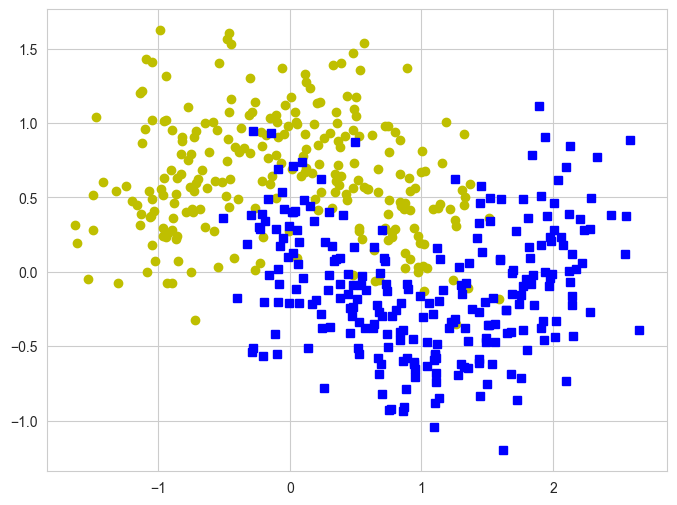

In [19]:
X, y = datasets.make_moons(n_samples=500, noise=0.30, random_state=SEED)

plt.figure(figsize=(8, 6))
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.show()

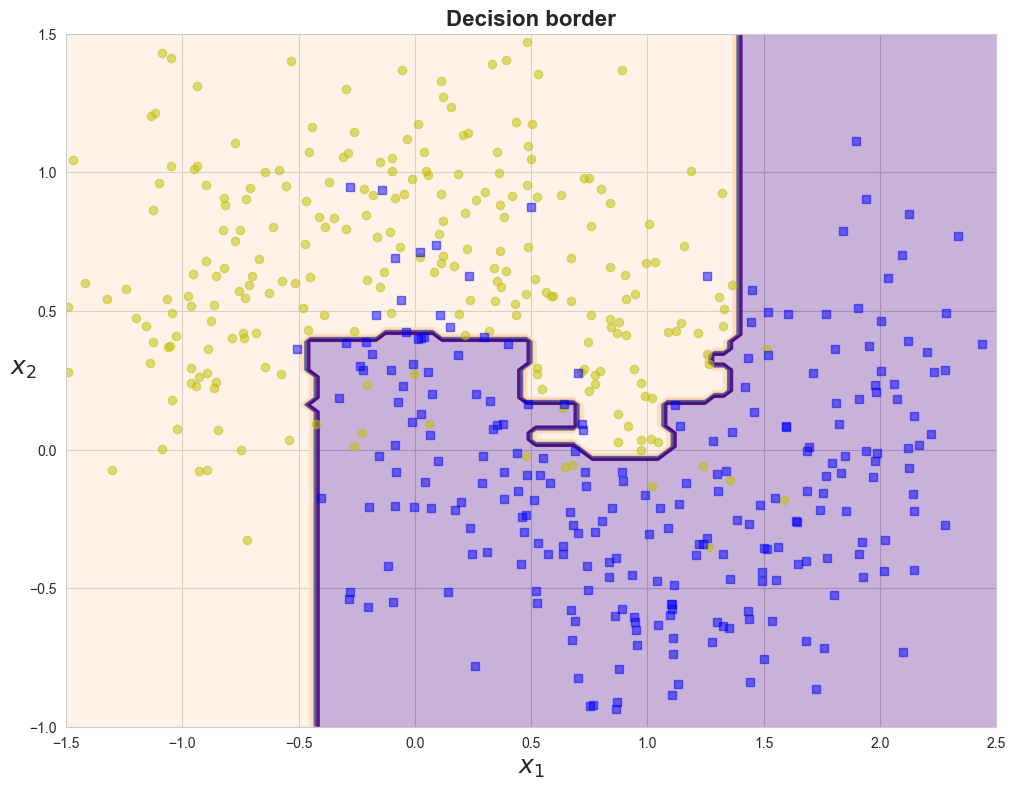

In [23]:
model = RandomForestClassifierCustom(max_depth=5, max_features=2,
                                     random_state=SEED)
model.fit(X, y)
plot_decision_boundary(model, X, y)
plt.title("Decision border", fontsize=16, fontweight="bold");

Select the best hyperparameters at which the dividing boundary will, in your opinion, be optimal in terms of bias-variance. You can also connect some metrics to select the best model.

In [ ]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)

parameters = {"n_estimators": list(range(11, 200, 5)),
              "max_depth" : list(range(1, 26)),
              "max_features": [1, 2], 
              "random_state": [SEED]}

cv_model = GridSearchCV(estimator=RandomForestClassifierCustom(),
                            param_grid=parameters,
                            scoring="accuracy",
                            n_jobs=-1)

cv_model.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifierCustom(), n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                       23, 24, 25],
                         'max_features': [1, 2],
                         'n_estimators': [11, 16, 21, 26, 31, 36, 41, 46, 51,
                                          56, 61, 66, 71, 76, 81, 86, 91, 96,
                                          101, 106, 111, 116, 121, 126, 131,
                                          136, 141, 146, 151, 156, ...],
                         'random_state': [111]},
             scoring='accuracy')

In [32]:
print(cv_model.best_estimator_)
print(cv_model.best_score_)

AttributeError: 'RandomForestClassifierCustom' object has no attribute 'best_estimator_'

precision_score: 0.9166666666666666
recall_score: 0.9166666666666666
f1_score: 0.9166666666666666
accuracy_score: 0.92


Text(0.5, 1.0, 'Classification with the best hyperparameters')

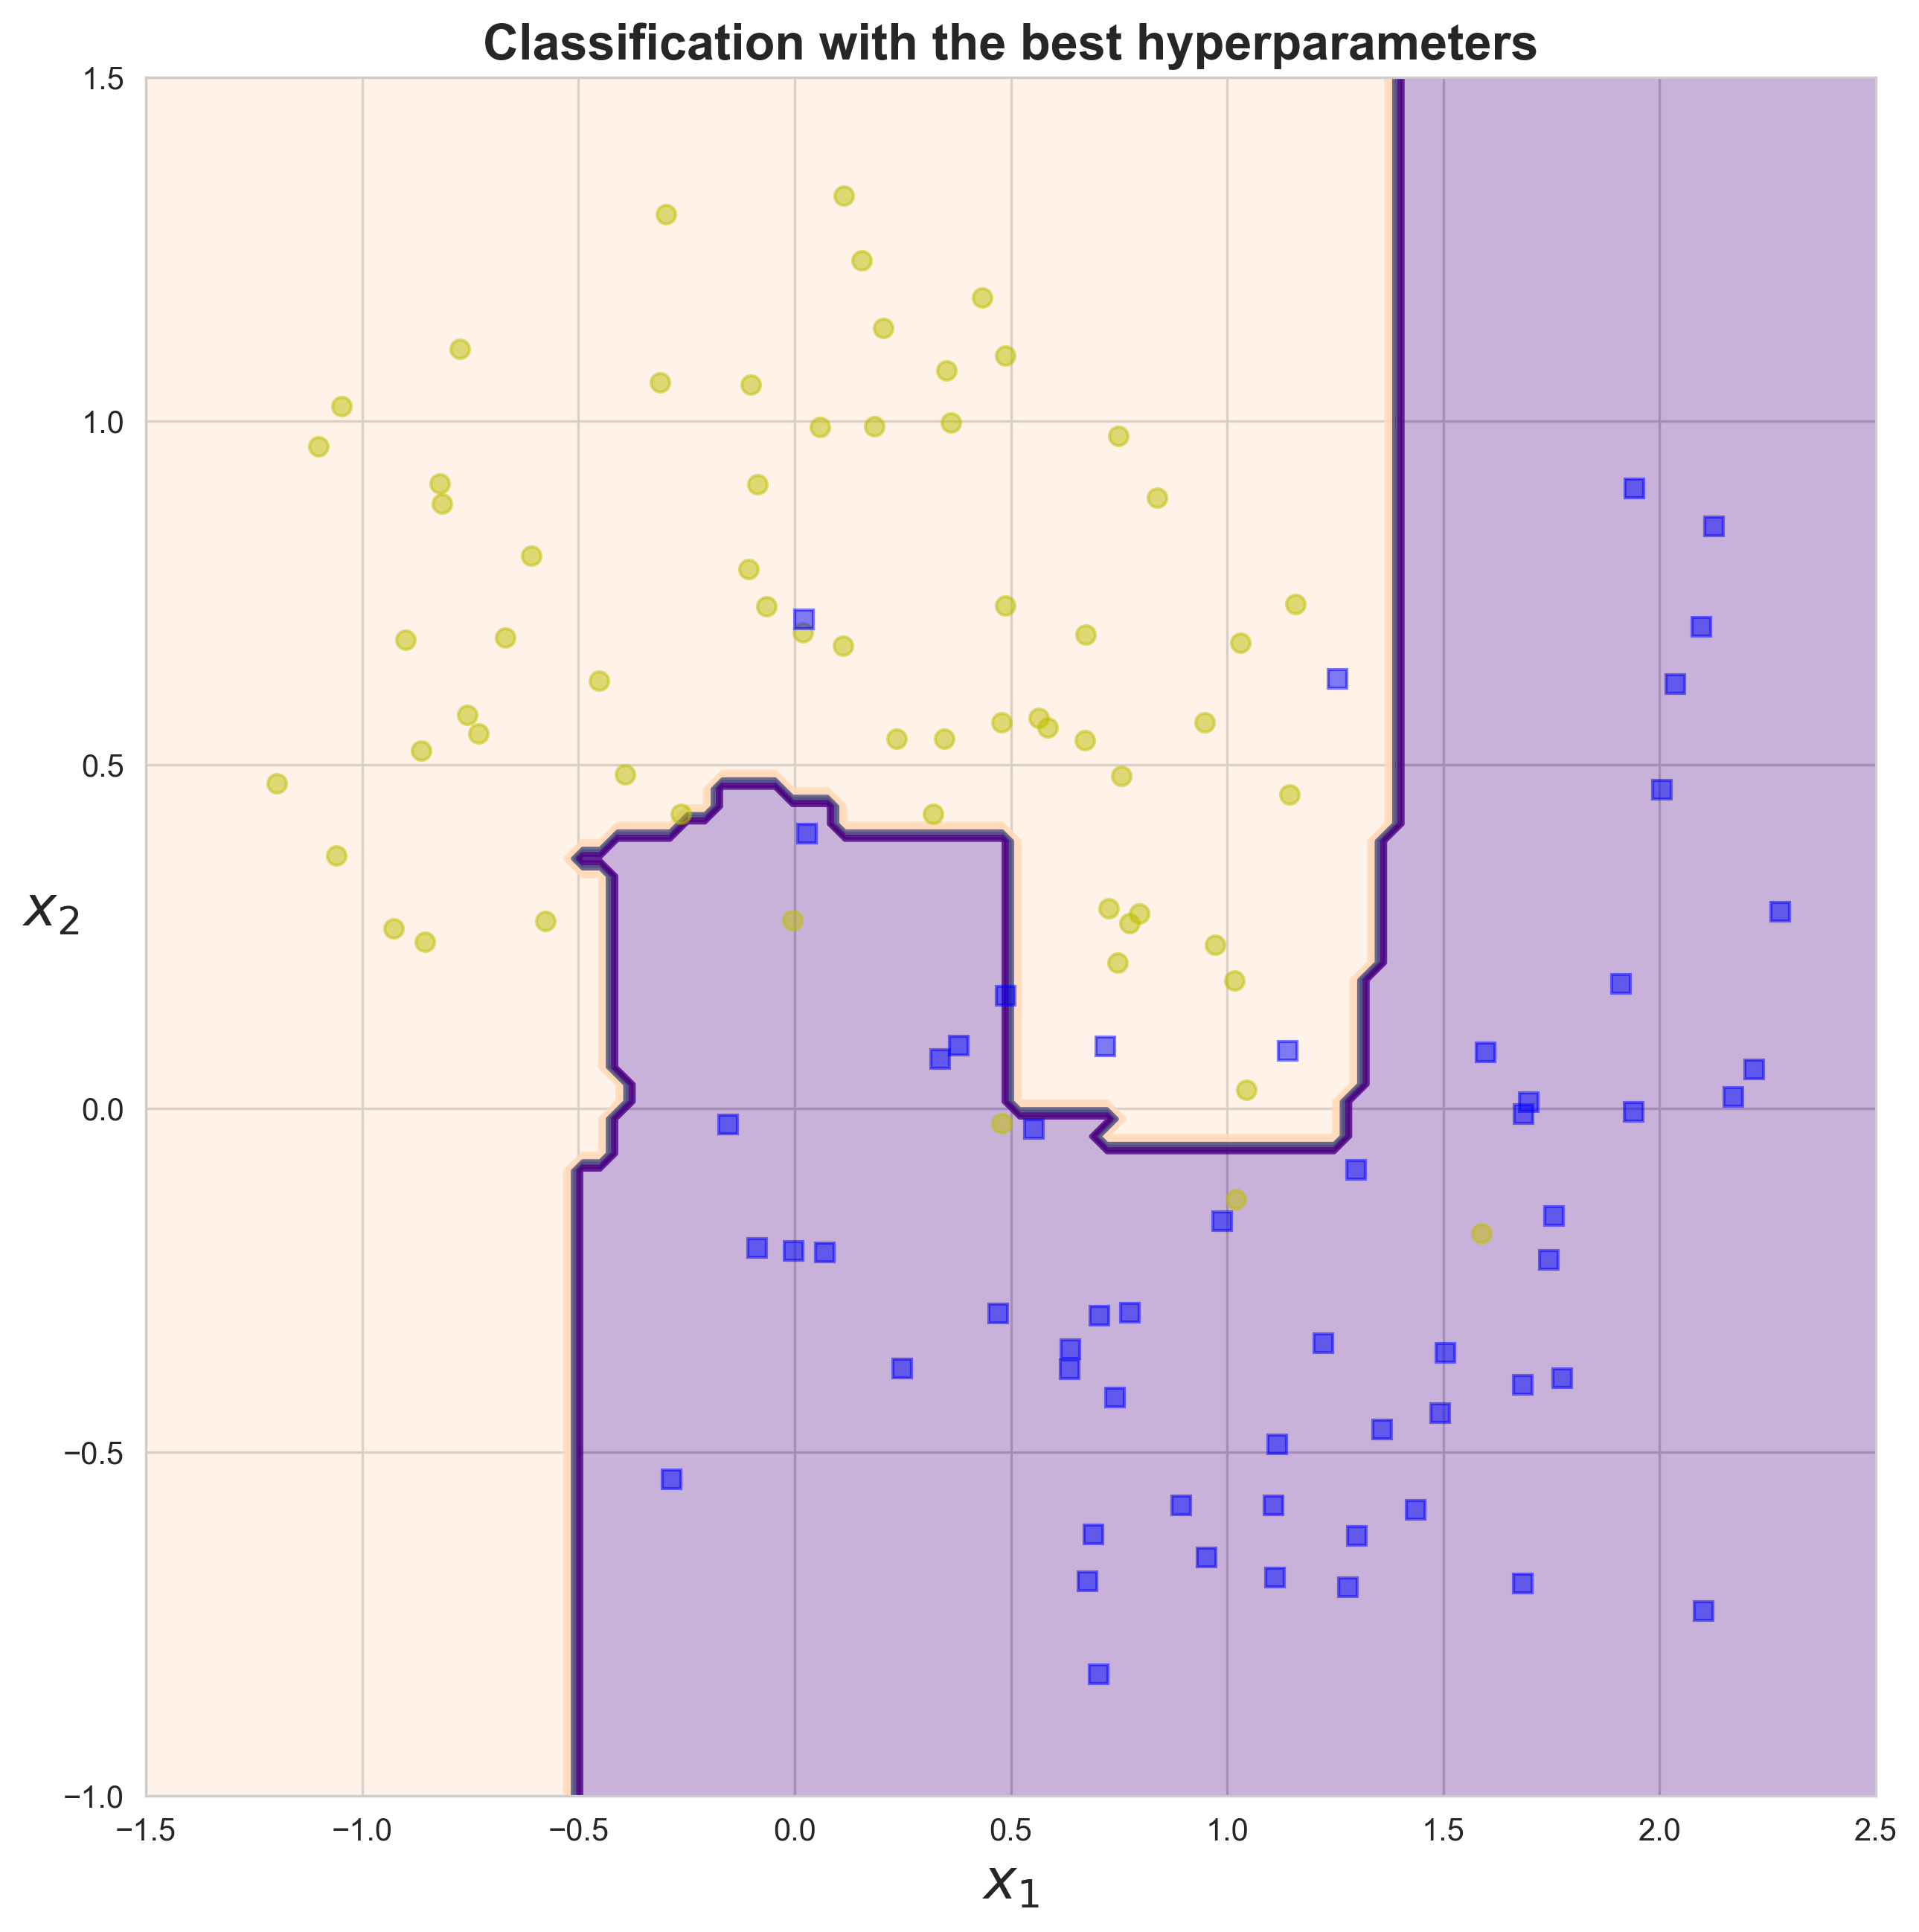

In [33]:
cv_model = RandomForestClassifierCustom(n_estimators=186, max_depth=5, max_features=2, random_state=SEED)
cv_model.fit(X_train, y_train)
y_pred = cv_model.predict(X_test)

metrics=[precision_score, recall_score, f1_score, accuracy_score]
for metric in metrics:
    print(f'{metric.__name__}: {metric(y_test, y_pred)}')

fig, ax = plt.subplots(figsize=(10,10), dpi=300)
plot_decision_boundary(cv_model, X_test, y_test)
plt.title("Classification with the best hyperparameters", fontsize=16, fontweight='bold')

#### Task 2. 3. Correlation of basic models

As we learned in lecture, for bagging to work well, the predictions of our models should not be highly correlated. To achieve this, various approaches are used in random forests, including RSM. Let's see how the `max_features` parameter affects the correlation of the base models in the random forest from `sklearn`. As an example, we will use the `breast_cancer` dataset. To calculate correlations, use the `base_model_pair_correlation` function below. For each model, you will get a set of values (pairwise correlations of all trees), then you can depict them in the form of boxplots, just as we drew the distribution of metrics in lecture.

In [34]:
# Функция для расчета попарных корреляций базовых моделей в случайном лесу
def base_model_pair_correlation(ensemble, X):
    corrs = []
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        ypred_t2 = est2.predict_proba(Xj_test)[:, 1]

        corrs.append(pearsonr(ypred_t1, ypred_t2)[0])
    return np.array(corrs)

In [35]:
# Загрузим данные
breast_cancer = datasets.load_breast_cancer()
X = breast_cancer.data
y = breast_cancer.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [6]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

In [42]:
list(range(1, X.shape[1], 2))

[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]

In [46]:
max_features = list(range(1, X.shape[1], 2))
max_features_dict = {}

for n_features in max_features:
    model = RandomForestClassifier(max_features=n_features)
    model.fit(X_train, y_train)
    max_features_dict[n_features] = base_model_pair_correlation(model, X_test)

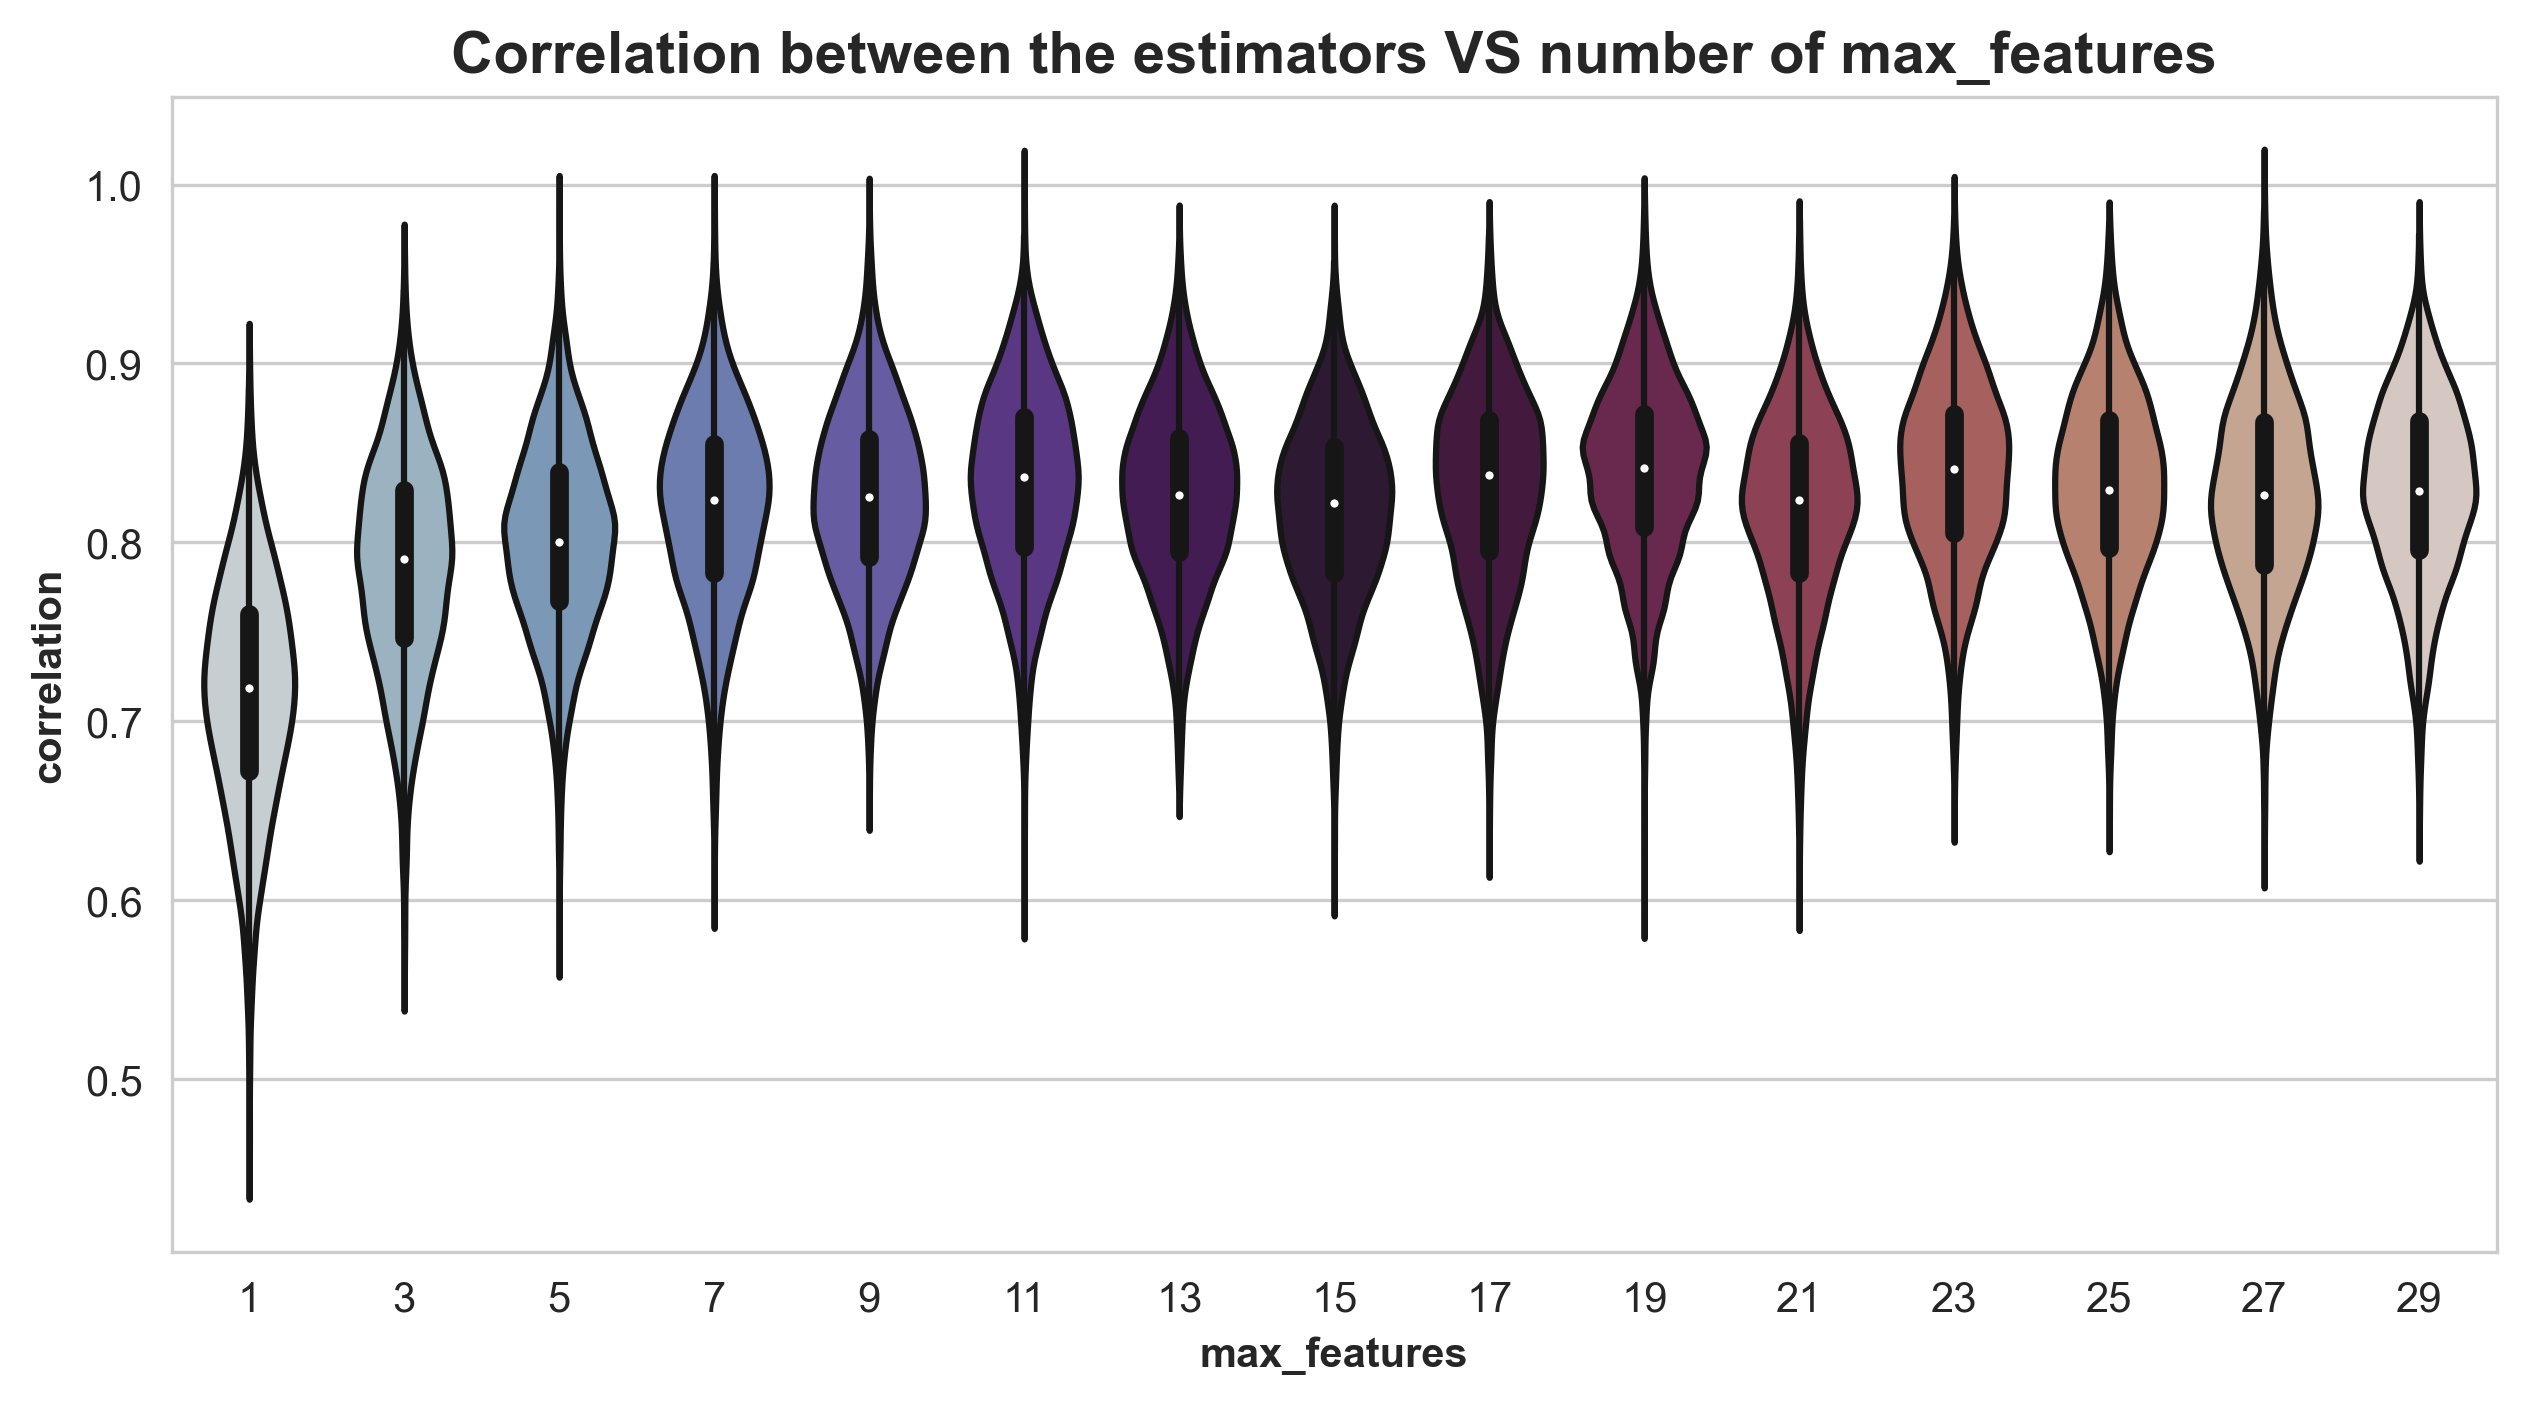

In [50]:
max_features_df = pd.DataFrame(max_features_dict)

fig, ax = plt.subplots(figsize=(10,5), dpi=300)
sns.violinplot(data=max_features_df, palette="twilight", ax=ax)
ax.set_title("Correlation between the estimators VS max_features", 
             fontsize=14, fontweight="bold")
ax.set_xlabel("max_features", fontweight="bold")
ax.set_ylabel("correlation", fontweight="bold");

Now let's see how the `max_depth` parameter affects this:

In [7]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

In [56]:
max_depth = [1, 2, 5, 10, 15, 25, 50, 100, 200]
max_depth_dict = {}

for md in max_depth:
    model = RandomForestClassifier(max_depth=md)
    model.fit(X_train, y_train)
    max_depth_dict[md] = base_model_pair_correlation(model, X_test)

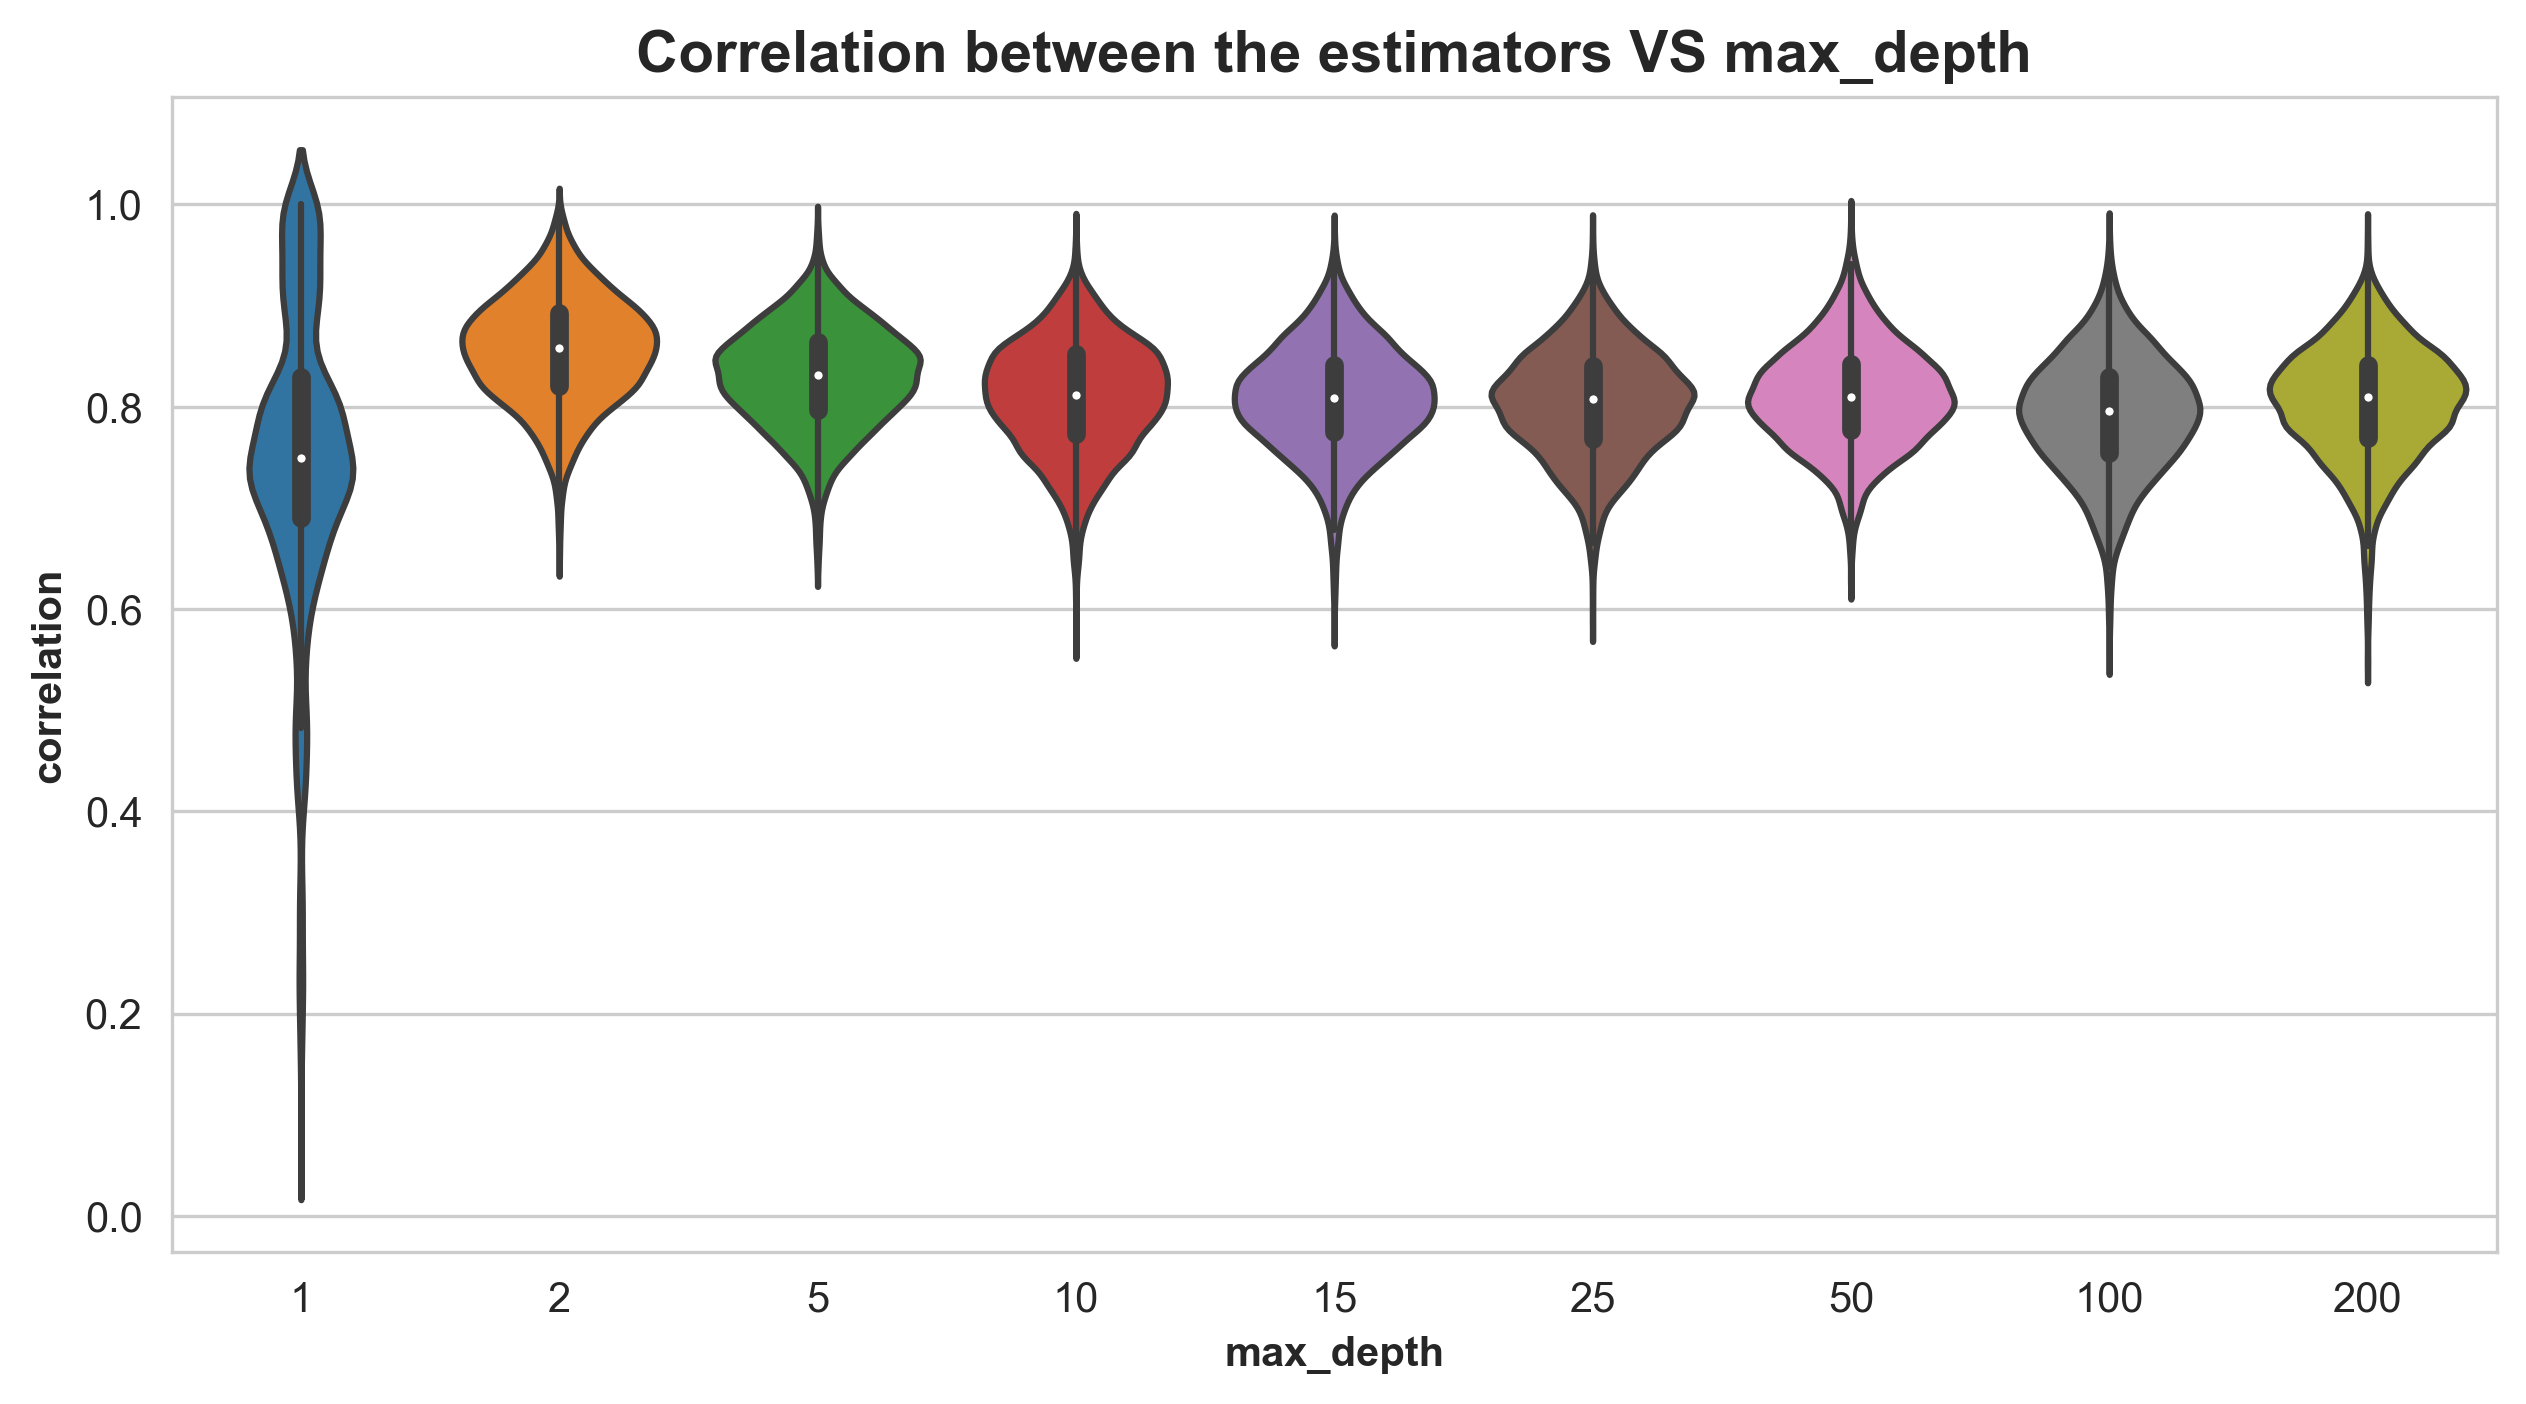

In [57]:
max_depth_df = pd.DataFrame(max_depth_dict)

fig, ax = plt.subplots(figsize=(10,5), dpi=300)
sns.violinplot(data=max_depth_df, ax=ax)
ax.set_title("Correlation between the estimators VS max_depth", 
             fontsize=14, fontweight="bold")
ax.set_xlabel("max_depth", fontweight="bold")
ax.set_ylabel("correlation", fontweight="bold");

Describe your observations:

* The larger `the max_features` parameter, the stronger is the correlation of estimators, with a plateau over 9;
* It looks like with `max_depth`= 1 correlation is the lowest. Maximum is at parameter equal 2. Beyond this correlation is reducing reaching plateau at some point. 1


### Task 3. Building a large ensemble

   



In this task, you need to diagnose heart disease in people using [medical indicators](https://www.kaggle.com/ronitf/heart-disease-uci).

In [59]:
# !gdown  --id 1VFbDK-Ad-hpf0_GGCBzn4thdn9mkQ-Y- -O heart.csv -q
heart_dataset = pd.read_csv("heart.csv")

In [60]:
X = heart_dataset.drop("target", axis=1)
y = heart_dataset["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)
X_train.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
178,43,1,0,120,177,0,0,120,1,2.5,1,0,3
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3
201,60,1,0,125,258,0,0,141,1,2.8,1,1,3
246,56,0,0,134,409,0,0,150,1,1.9,1,2,3
153,66,0,2,146,278,0,0,152,0,0.0,1,1,2


Train a variety of classifiers below, as well as an ensemble of `VotingClassifier` from `sklearn.ensemble` combining these classifiers using hard or soft voting (parameter `voting = `'hard'` or `'soft'` respectively). Evaluate the quality of models using cross-validation on the training set using the `cross_val_score` function and the `f1` metric. We didn’t go through some of the models from here, you can read more about them, but in principle, for the task it is not very important to know the principles of their operation (but, if you have time, then read it, it’s interesting).

In [61]:
dt = DecisionTreeClassifier(random_state=SEED, max_depth=10, min_samples_leaf=10)
rf = RandomForestClassifier(n_estimators=50, random_state=SEED)
etc = ExtraTreesClassifier(random_state=SEED)
knn = KNeighborsClassifier(n_neighbors=5, weights="distance")
svc_lin = SVC(kernel='linear', probability=True, random_state=SEED)
svc_rbf = SVC(kernel='rbf', probability=True, random_state=SEED)
cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED)
lgbm = lightgbm.LGBMClassifier(random_state=SEED)
lgbm_rf = lightgbm.LGBMClassifier(boosting_type="rf", bagging_freq=1, bagging_fraction=0.7, random_state=SEED)
xgb = xgboost.XGBClassifier(random_state=SEED)
xgb_rf = xgboost.XGBRFClassifier(random_state=SEED)
lr = LogisticRegression(solver='liblinear', max_iter=10000)
nb = GaussianNB()

base_models = [("DT", dt), ("RF", rf), 
               ("ETC", etc), ("KNN", knn), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               ("CAT", cat), ("LGBM", lgbm), 
               ("LGBM_RF", lgbm_rf), ("XGB", xgb), 
               ("XGB_RF", xgb_rf), ("LR", lr), ("NB", nb)]

Various warnings may appear here when training boosters, don't worry, everything is fine, they're just usually very talkative)

In [8]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##



## END YOUR CODE HERE ##

for model in [dt, rf, cat, etc, knn, svc_lin, svc_rbf, xgb, lgbm, xgb_rf, lgbm_rf, lr, nb, voting_hard, voting_soft]: 
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="f1")
    print(f"{model.__class__.__name__}: {scores.mean()}")

Вы можете заметить, что ансамбль показывает хорошее, но не лучшее качество предсказания, попробуем его улучшить. Как вы знаете, ансамбли работают лучше, когда модели, входящие в них не скоррелированы друг с другом. Определите корреляцию предсказаний базовых моделей в ансамбле на тестовом наборе данных, и удалите из ансамбля те модели, чьи предсказания будут сильнее коррелировать с остальными. Воспользуйтесь функцией `base_model_pair_correlation_for_voting_clf`. **Спойлер**: далеко не факт, что если вы удалите две модели с корреляцией 0.95, то все станет сильно лучше, здесь все будет немного сложнее. Чтобы добиться максимального качества может понадобиться долгий перебор различных комбинаций моделей. Наилучший скор, который мне удалось достичь, это 0.915, но он получен весьма странной комбинацией алгоритмов, а еще и простым перебором всех вариантов)

In [127]:
def base_model_pair_correlation_for_voting_clf(ensemble, X):
    corrs = []
    base_model_names = [f"{est.__class__.__name__}" for est in ensemble.estimators_]
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        if not isinstance(est1, SVC):
            ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t1 = est1.decision_function(Xi_test)


        if not isinstance(est2, SVC):
            ypred_t2 = est2.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t2 = est2.decision_function(Xi_test)
        corrs.append((est1, est2, pearsonr(ypred_t1, ypred_t2)[0]))


    return corrs

In [9]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

### Задание 4. Определение оттока клиентов из телекома

**6 баллов + 7 дополнительных за высокое качество модели и различные эксперименты**

Будем предсказывать, уйдет ли от нас клиент (переменная `Churn?`). Данные можно скачать [здесь](https://www.kaggle.com/venky12347/churn-telecom). Это будет уже совсем взрослое задание, так как правильного ответа на него нет. Вам нужно будет разобраться с данными, правильно подготовить их для моделей, а также выбрать лучшую модель. 

Задача минимум:

Выберите 2 модели &mdash; один случайный лес и один бустинг из приведенных ниже:

1. `xgboost.XGBClassifier`
2. `xgboost.XGBRFClassifier` &mdash; случайный лес от xgboost
3. `lightgbm.LGBMClassifier`
4. `lightgbm.LGBMClassifier(boosting_type="rf")` &mdash; случайный лес от lightgbm
5. `catboost.CatBoostClassifier`

И попробуйте разобраться с тем, как для этих моделей правильно настраивать гиперпараметры. Советую гуглить примерно следующее `how to choose best hyperparameters for lightgbm`. Там вы найдете кучу сложного и непонятного кода, но если с ним разобраться и научиться обучать нестандартные бустинги, то в плане табличных данных равных вам не будет)

In [130]:
data = pd.read_csv("churn.csv")
data.head()

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,...,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.
